# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [1]:
#general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm

## Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Data loading functions. Uncomment the one you want to use
import pandas as pd
from worcliver.load_data import load_data

data = load_data()


### Dividing our data into test-, training- and validation-set

The dataset should be randomly divided into :
* training datasets = 70 % of samples
* test datasets = 20 % of samples
* validation datasets = 10 % of samples

In [3]:
amount_in_training = round(len(data.index)*0.7)
amount_in_test = round(len(data.index)*0.2)
amount_in_validation = len(data.index) - amount_in_training - amount_in_test

#split the data into training+validation data and test data
training_data, test_data = model_selection.train_test_split(data, test_size=(amount_in_test) / len(data), random_state=42)
#random_state is set to a fixed value (in this case 42, which is an onofficial standard in machine learning), which ensures 
#that the same random division is made every time this code is ran.
# --> to ensure that this is reproducible

###

#wat ik begreep uit college is dat validation en training samen blijven totdat je echt gaat trainen? dus inspectie is over deze 2 samen?

###

#checking the lengths
print(f'Training + validation: {len(training_data)} samples, Test: {len(test_data)} samples.')
print(f'So total number of samples: {len(training_data)+len(test_data)}')

Training + validation: 149 samples, Test: 37 samples.
So total number of samples: 186


### Data inspection

In [4]:
print(f'The number of samples: {len(training_data.index)}')
print(f'The number of columns: {len(training_data.columns)}')

training_data_df = pd.DataFrame(training_data)
#print(data_df.head())
print(training_data_df.info())
#print(data_df.describe())
cat_cols = training_data_df.select_dtypes(include=["object"]).columns
num_cols = training_data_df.select_dtypes(include=["number"]).columns
print(f"categorical columns: {len(cat_cols)}")
print(f'numerical columns: {len(num_cols)}')

no_variation_samples = 0
for sample in training_data.index:
    data_sample = training_data.drop(columns=['label'])
    if data_sample.loc[sample].max() == data_sample.loc[sample].min():
        no_variation_samples += 1
no_variation_col = 0
for feature in training_data.columns:
    if training_data[feature].max() == training_data[feature].min():
        no_variation_col += 1
print(f'samples with no variation: {no_variation_samples}')
print(f'columns with no variation: {no_variation_col}')

label = training_data[['label']]
malignant_count = (label == "malignant").sum()
benign_count = (label == "benign").sum()

print(f'Class Distribution: malignant {malignant_count} and benign {benign_count}')

The number of samples: 149
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, Liver-030_0 to Liver-103_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 576.2+ KB
None
categorical columns: 1
numerical columns: 493
samples with no variation: 0
columns with no variation: 19
Class Distribution: malignant label    76
dtype: int64 and benign label    73
dtype: int64


### Extracting the label per patient

This label (benign/malignant) is the ground truth per patient.

In [5]:
label_training = training_data[['label']]
training_data.drop(columns=['label'], inplace=True)

label_training_binary = label_training.copy()
label_training_binary['label'] = label_training_binary['label'].map({'malignant': 1, 'benign': 0})


### Finding the missing data

Checking whether the missing data is stored as NaN or 0, finding the columns in which missing data is found as well as the empty features.


In [6]:
#making a dataframe
data_training = pd.DataFrame(training_data)

#checking whether missing data is stored as NaN
nan_check = data_training.isna()

#conclusion: missing data is not stored as NaN

#checking whether missing data is stored as 0
zero_counts = (data_training == 0).sum()

#conclusion: missing data is stored as 0; however is this true? values in Radiomics can also be calculated as being 0, so how do you know if 0 is the
#intended value, or a missing value? you can't, so do not consider the zeros as missing data.

zero_counts_columns = zero_counts[zero_counts > 0]
print(f'The number of features in which there is missing data: {zero_counts_columns.count()}')
print(f'The number of missing data is: {sum(zero_counts_columns)}')

The number of features in which there is missing data: 29
The number of missing data is: 3488


### Handling the missing data

The missing data was handled as follows:
1. Deleting the empty features from the data
2. Replacing the missing data with the median value

In [7]:
#step 1: deleting the empty features from the data
#a feature is empty when it contains values for <30% of the samples
#   empty_features = the features that are considered empty
#   missing_data_features = the features that contain missing data
empty_features = []
missing_data_features = []

# for feature, missing_data in zero_counts_columns.items():  
#     if missing_data > 0.7*len(data_training.index):
#         empty_features.append(feature)
#     else:
#         missing_data_features.append(feature)
#         print(f'The amount of data missing in {feature} is {missing_data}')

data_training_clean = data_training.drop(columns=empty_features)

print(f'Empty features: {len(empty_features)}, Features with missing data: {len(missing_data_features)}.')

Empty features: 0, Features with missing data: 0.


In [8]:
#step 2: replacing the missing data with the median
# for feature in missing_data_features:
#     data_training_clean[feature].replace(0, np.nan, inplace=True)
    
#     # Vervang de NaN waarden door de mediaan
#     median_value = data_training_clean[feature].median()
#     data_training_clean[feature].fillna(median_value, inplace=True)
check_zero_counts = (data_training_clean == 0).sum()
check_zero_counts_columns = check_zero_counts[check_zero_counts > 0]
print(f'To check: the number of features in which there is missing data is now: {check_zero_counts_columns.count()}')

To check: the number of features in which there is missing data is now: 29


### Pre-processing: standardization/normalization

First is tested whether the data is normally distributed or not with the Shapiro-Wilk Test. 
* p-value > 0.05: the data is likely normally distributed
* p-value < 0.05: the data is likely not normally distributed

In [9]:
shapiro_results = {}
no_variation = 0
features_no_variation = []

for feature in data_training_clean.columns:
    if data_training_clean[feature].max() == data_training_clean[feature].min():
        shapiro_results[feature] = None  #skipping the feature when there is no variation
        no_variation += 1
        features_no_variation.append(feature)
    else:
        #Shapiro-Wilk test to check for normality
        stat, p_value = stats.shapiro(data_training_clean[feature])

        #if normally distributed, store 1, else store 0
        if p_value > 0.05:
            result = 1
        else:
            result = 0

        shapiro_results[feature] = result

#the number of normally distributed features
print(f'The number of features that do not have variation in their values is: {no_variation}')
print(f'The number of normally distributed features is: {sum(1 for result in shapiro_results.values() if result == 1)}')
print(f'The number of not normally distributed features is: {sum(1 for result in shapiro_results.values() if result == 0)}')

#deleting the features in which there was no variation
data_training_clean = data_training_clean.drop(columns=features_no_variation)



The number of features that do not have variation in their values is: 19
The number of normally distributed features is: 48
The number of not normally distributed features is: 426


#### Standardization

In [10]:
#code from workgroup; sklearn package has a function that standardizes the data, so this is applied here:
scaler = preprocessing.StandardScaler()
data_training_standardized = scaler.fit_transform(data_training_clean)

### Normalization

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
data_training_normalized = min_max_scaler.fit_transform(data_training_standardized)
data_training_normalized_df = pd.DataFrame(data_training_normalized, columns=data_training_clean.columns)

### Correlation

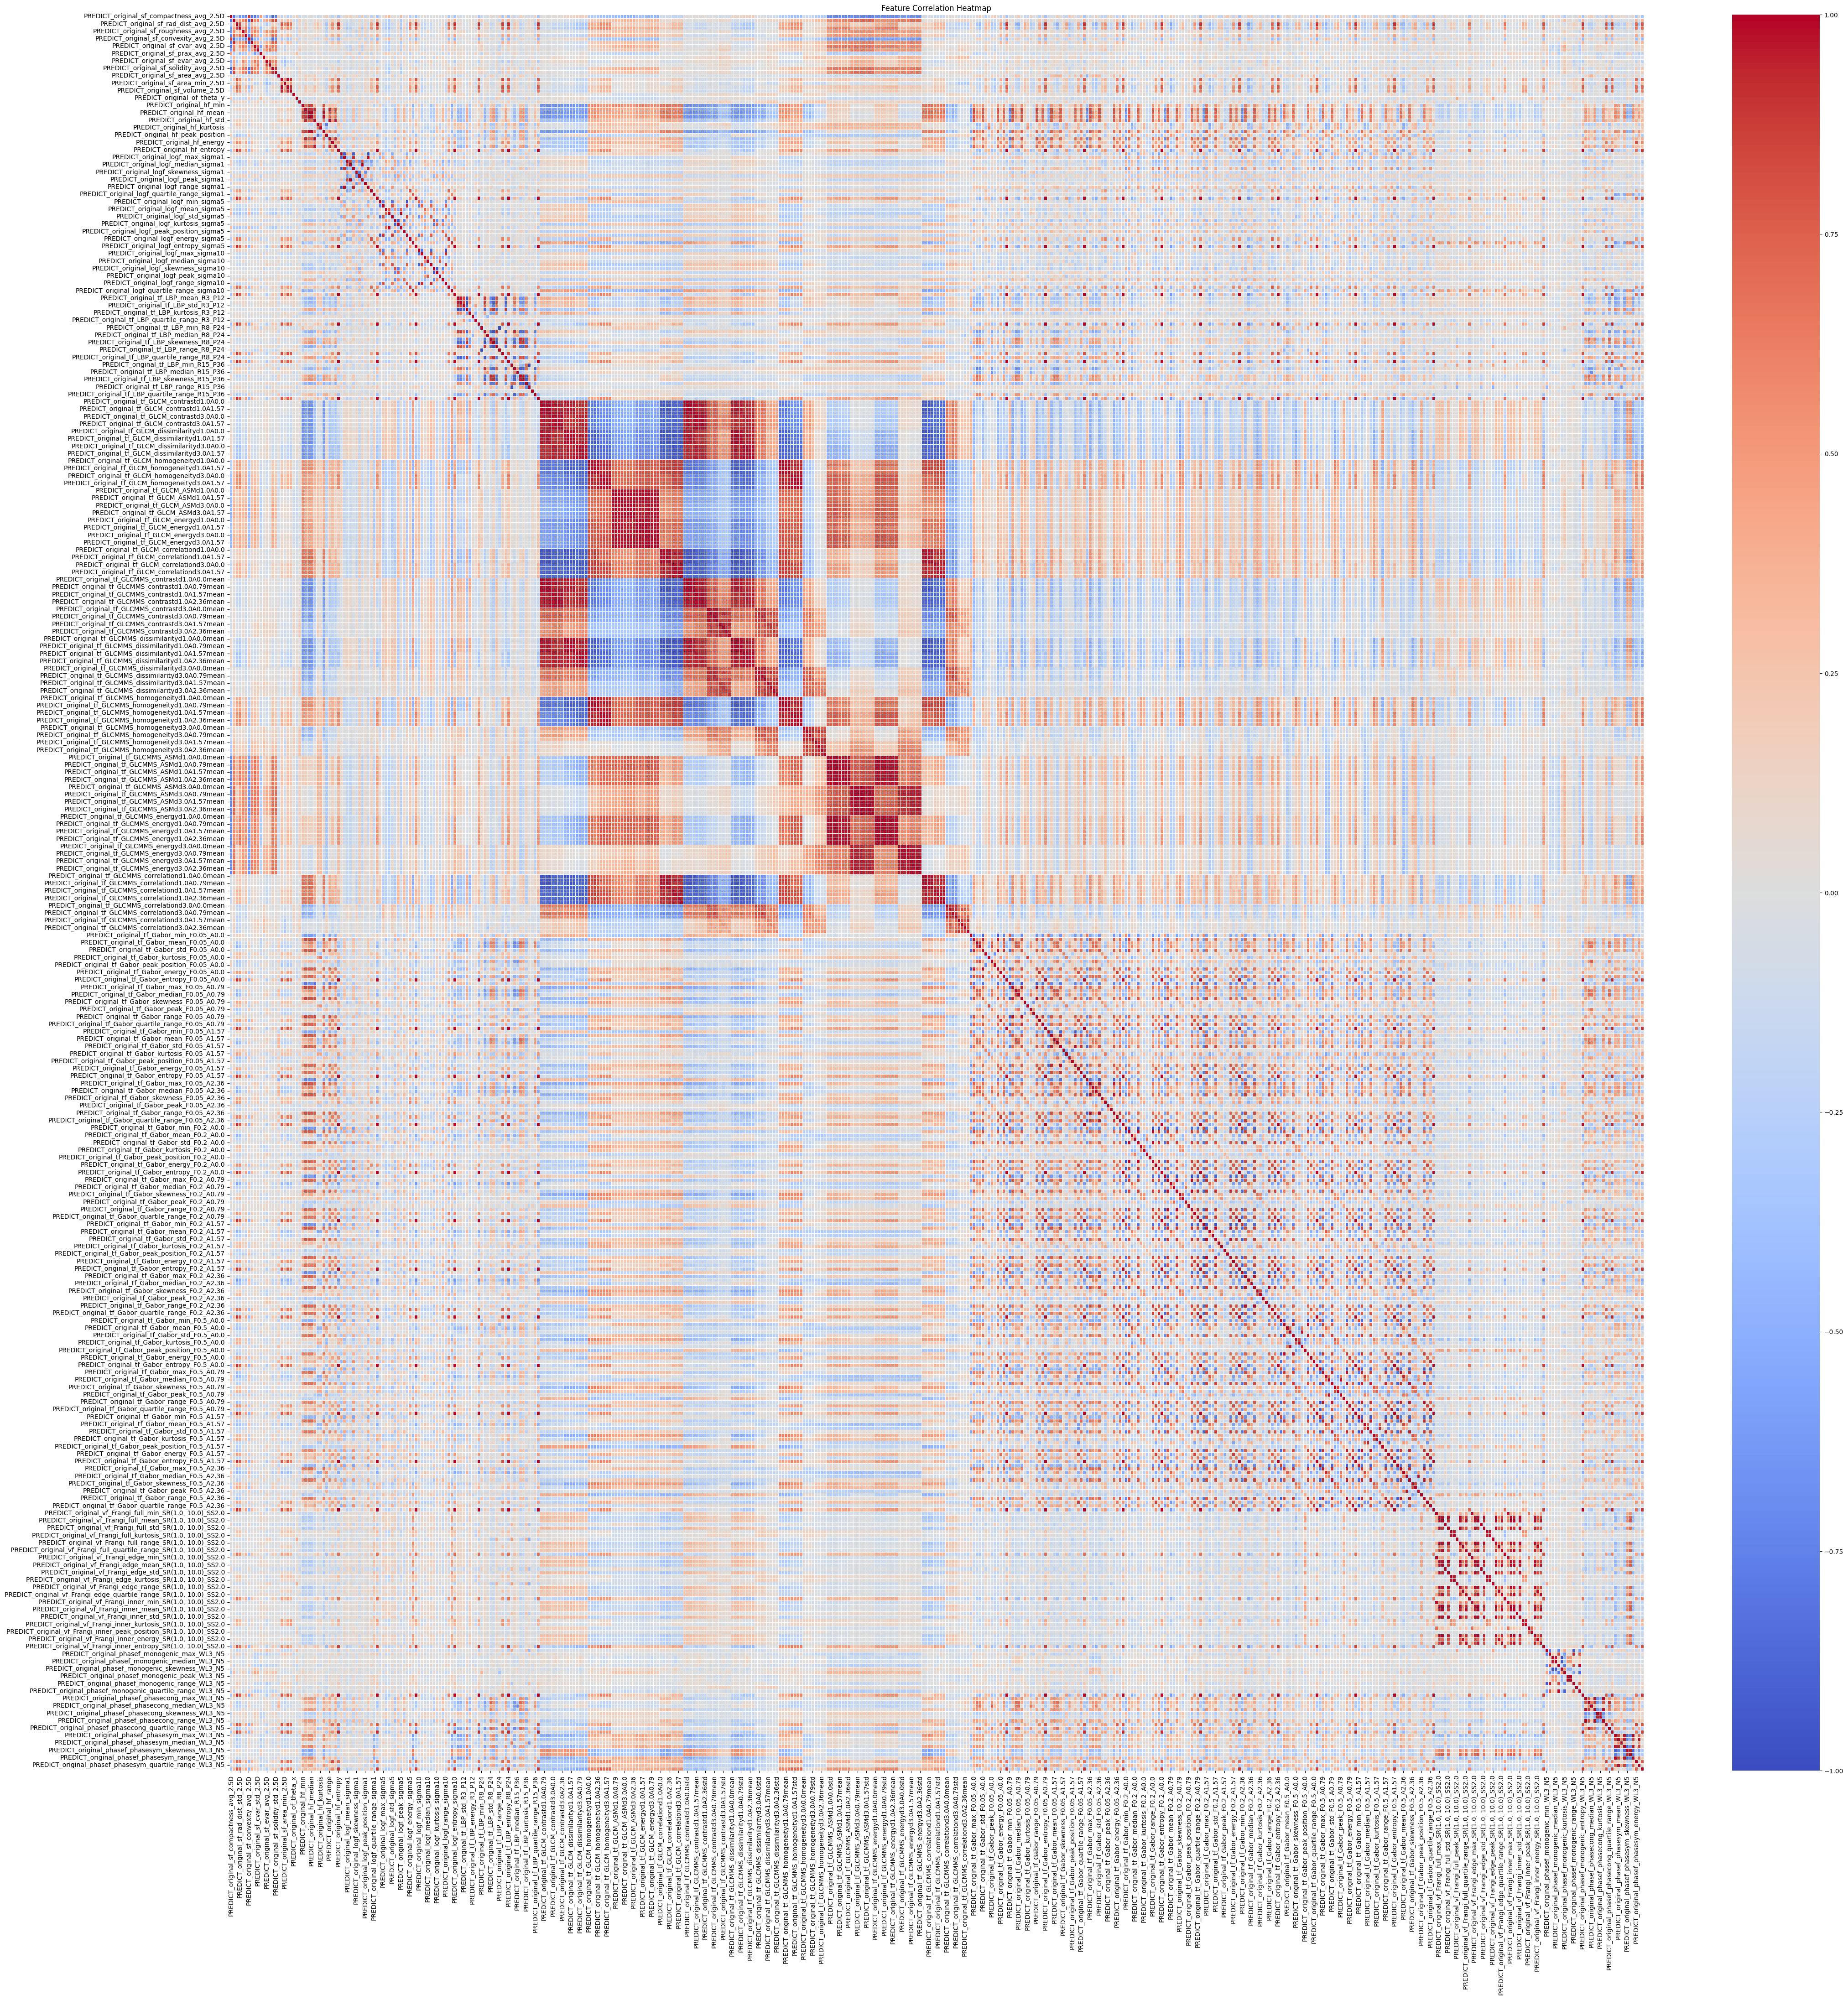

In [13]:
corr_matrix = data_training_normalized_df.corr()

plt.figure(figsize=(50, 50))
seaborn.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Feature selection

In [14]:
threshold = 0.9  
high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                      for x, y in zip(*high_corr_pairs) if x != y]
print(f'There are {len(high_corr_features)} feature pairs with a correlation above {threshold}')

There are 3876 feature pairs with a correlation above 0.9


### Random forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
label_training_array = label_training_binary.values.flatten()
input_random_forest = data_training_normalized_df.values
from sklearn.ensemble import RandomForestClassifier

n_trees = [50, 100, 200]
bootstraps = [True, False]
max_depths = [50, 100, None]
min_splits = [2, 5, 10]


for n_tree in n_trees:
    for bootstrap in bootstraps:
        for max_depth in max_depths:
            for min_split in min_splits:
                forest = RandomForestClassifier(n_estimators=n_tree, bootstrap=bootstrap)

                X_train, X_validate, y_train, y_validate = model_selection.train_test_split(input_random_forest, label_training_array, test_size=0.3, random_state=42)


                # Fit the model on the training data
                forest.fit(X_train, y_train)

                # Predict on the test set
                y_pred = forest.predict(X_validate)

                # Compute accuracy
                accuracy = metrics.accuracy_score(y_validate, y_pred)

                print(f"Accuracy for {n_tree} trees, bootstrap {bootstrap}, max_depth {max_depth} and min_split {min_split}: {accuracy * 100:.2f}%")




Accuracy for 50 trees, bootstrap True, max_depth 50 and min_split 2: 73.33%
Accuracy for 50 trees, bootstrap True, max_depth 50 and min_split 5: 68.89%
Accuracy for 50 trees, bootstrap True, max_depth 50 and min_split 10: 73.33%
Accuracy for 50 trees, bootstrap True, max_depth 100 and min_split 2: 66.67%
Accuracy for 50 trees, bootstrap True, max_depth 100 and min_split 5: 62.22%
Accuracy for 50 trees, bootstrap True, max_depth 100 and min_split 10: 64.44%
Accuracy for 50 trees, bootstrap True, max_depth None and min_split 2: 68.89%
Accuracy for 50 trees, bootstrap True, max_depth None and min_split 5: 68.89%
Accuracy for 50 trees, bootstrap True, max_depth None and min_split 10: 64.44%
Accuracy for 50 trees, bootstrap False, max_depth 50 and min_split 2: 71.11%
Accuracy for 50 trees, bootstrap False, max_depth 50 and min_split 5: 62.22%
Accuracy for 50 trees, bootstrap False, max_depth 50 and min_split 10: 62.22%
Accuracy for 50 trees, bootstrap False, max_depth 100 and min_split 2: 6

In [ ]:
# Get feature importances and compute standard deviation
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Print the top 5 most important features
print("Top 5 features by importance:")
for i in range(5):
    print(f"Feature {indices[i]}: {importances[indices[i]]:.4f}")

### Suport Vector Machine

In [ ]:
from sklearn import model_selection
from sklearn.svm import SVC
label_training_array = label_training_binary.values.flatten()
input_SVM = data_training_normalized_df.values

# Construct classifiers
degrees = [1, 3, 5]
coef0s = [0.01, 0.5, 1]
slacks = [0.01, 0.5, 1]

for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            SVM = SVC(kernel='poly', degree=degree, coef0=coef0, C=slack, gamma='scale')

            X_train, X_validate, y_train, y_validate = model_selection.train_test_split(
                input_SVM, label_training_array, test_size=0.3, random_state=42)
            
            # Fit the model on the training data
            SVM.fit(X_train, y_train)

            # Predict on the test set
            y_pred = SVM.predict(X_validate)

            # Compute accuracy
            accuracy = metrics.accuracy_score(y_validate, y_pred)

            print(f"Accuracy for SVM with polynomial kernel \
                   degree = {degree}, coef0 = {coef0}, slack = {slack} : {accuracy * 100:.2f}%")    

Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 0.01, slack = 0.01 : 40.00%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 0.01, slack = 0.5 : 60.00%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 0.01, slack = 1 : 66.67%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 0.5, slack = 0.01 : 40.00%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 0.5, slack = 0.5 : 60.00%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 0.5, slack = 1 : 66.67%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 1, slack = 0.01 : 40.00%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 1, slack = 0.5 : 60.00%
Accuracy for SVM with polynomial kernel                    degree = 1, coef0 = 1, slack = 1 : 66.67%
Accuracy for SVM with polynomial kernel                    de

In [21]:
X_train_SVM, X_validate_SVM, y_train_SVM, y_validate_SVM = model_selection.train_test_split(input_SVM, label_training_array, test_size=0.2, random_state=42)

SVM = SVC(kernel='poly')

param_grid = {
    'degree': [1, 3, 5],                 #degree of polynomial
    'coef0': [0.01, 0.5, 1],             #homogeniteit van de kernel
    'C': [0.01, 0.5, 1],                 #slacks
}

# Initialize GridSearchCV
grid_search = model_selection.GridSearchCV(SVM, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_train_SVM, y_train_SVM)

# Resultaten ophalen en sorteren
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by="mean_test_score", ascending=False)

# Drie beste modellen tonen
top_3_models = results[["param_degree", "param_coef0", "param_C", "mean_test_score"]].head(3)
print("Top 3 beste modellen:")
print(top_3_models)

# Beste model selecteren en testen op validatieset
best_SVM = grid_search.best_estimator_
accuracy = best_SVM.score(X_validate_SVM, y_validate_SVM)
print(f"Accuracy Validation set: {accuracy:.2f}")
# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)



Fitting 10 folds for each of 27 candidates, totalling 270 fits
Top 3 beste modellen:
    param_degree  param_coef0  param_C  mean_test_score
8              5         1.00     0.01         0.790152
13             3         0.50     0.50         0.789394
10             3         0.01     0.50         0.781061
Accuracy Validation set: 0.83
Best Hyperparameters: {'C': 0.01, 'coef0': 1, 'degree': 5}
